## Compute thickness of post-avulsion deposits
This notebook is designed to take polylines from the top and base of the post-avulsion "T2" ridge and compute the ridge thickness between them. 

In [1]:
### Install necessary libraries
# pip install numpy geopandas scipy matplotlib

### Library Imports

In [2]:
import numpy as np
import geopandas as gpd
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# Ensure that text is saved as editable text objects
plt.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
plt.rcParams['ps.fonttype'] = 42   # Embed fonts as TrueType
plt.rcParams['font.family'] = 'Helvetica'


### Read in the points as shapefiles
The data here are vertices extracted from polylines representing the top and base of the T2 ridge

In [10]:
lower_pts = gpd.read_file('../field_data/polylines/t2_thickness/t2_base_points.shp')
upper_pts = gpd.read_file('../field_data/polylines/t2_thickness/t2_top_points.shp')
upper_pts.head()

,local_idx,vertex_ind,vertex_par,vertex_p_1,distance,angle,geometry
0,1,0,0,0,0.000000,199.178181,POINT Z (563018.262 4303656.046 1353.417)
1,1,1,0,1,1.128615,195.218586,POINT Z (563017.891 4303654.980 1353.506)
2,1,2,0,2,2.545595,205.356773,POINT Z (563017.614 4303653.590 1353.536)
3,1,3,0,3,3.337102,201.784617,POINT Z (563017.111 4303652.979 1353.707)
4,1,4,0,4,5.218905,197.299489,POINT Z (563016.976 4303651.102 1353.649)


### Read geometries into 3D numpy arrays

In [11]:
def extract_pts_2_numpy(gdf):
    """
    Extracts 3D points from the geometry column of a GeoDataFrame into a NumPy array.

    Parameters:
    - gdf (GeoDataFrame): A GeoDataFrame containing 3D points in the geometry column.

    Returns:
    - points_3d (ndarray): A NumPy array containing the 3D points extracted from the GeoDataFrame.
    """

    # Extract x, y, and z coordinates from the geometry column
    coordinates = gdf['geometry'].apply(lambda point: (point.x, point.y, point.z))

    # Convert to NumPy array
    points_3d = np.array(coordinates.tolist())

    return points_3d

In [12]:
base_pts = extract_pts_2_numpy(lower_pts)
top_pts = extract_pts_2_numpy(upper_pts)
top_pts[:5]

array([[5.63018262e+05, 4.30365605e+06, 1.35341748e+03],
       [5.63017891e+05, 4.30365498e+06, 1.35350598e+03],
       [5.63017614e+05, 4.30365359e+06, 1.35353613e+03],
       [5.63017111e+05, 4.30365298e+06, 1.35370679e+03],
       [5.63016976e+05, 4.30365110e+06, 1.35364880e+03]])

### Compute their offset using nearest neighbor
In the next cell, we compute the offset on a point-by-point basis and report the mean, standard deviation, and median

In [15]:
# Perform nearest neighbor search
tree = cKDTree(top_pts[:, :2])  # Create a KD-tree for data2 using only x and y coordinates

z_offsets = []
for point1 in base_pts:
    # Find the index of the nearest neighbor in data2
    _, idx = tree.query(point1[:2])  # Consider only x and y coordinates for the query

    # Compute the z-offset between corresponding points
    z_offset = top_pts[idx, 2] - point1[2]
    z_offsets.append(z_offset)

# Make z_offsets into an array
z_offset_array = np.asarray(z_offsets)
# Print or use the z-offset values as needed
print(f'mean offset value: {np.mean(z_offset_array):.2f}m')
print(f'standard deviation value: {np.std(z_offset_array):.2f} m')
print(f'median offset value: {np.median(z_offset_array):.2f} m')

mean offset value: 4.47m
standard deviation value: 3.30 m
median offset value: 3.42 m


### Inspect distribution of offsets

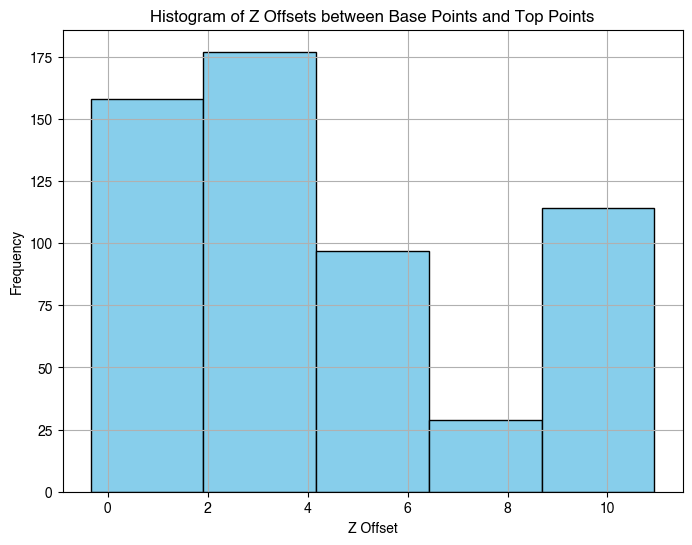

In [16]:
# Plot histogram of z offsets
plt.figure(figsize=(8, 6))
plt.hist(z_offset_array, bins=5, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Z Offset')
plt.ylabel('Frequency')
plt.title('Histogram of Z Offsets between Base Points and Top Points')

# Show plot
plt.grid(True)
plt.show()

### Visualize for QC purposes
Plot the vertices and the lines connecting nearest neighbors

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


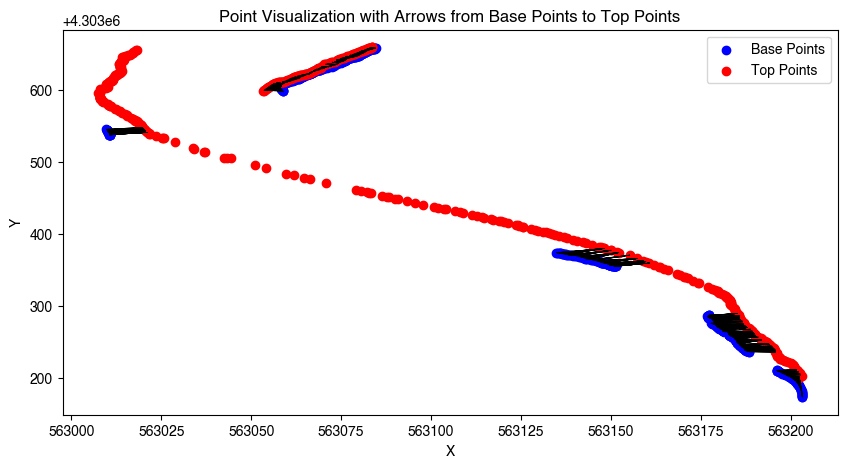

In [18]:
# Build KD tree for top_pts
tree = cKDTree(top_pts[:, :2])  # Consider only x and y coordinates for KD tree

# Find nearest neighbors for each point in base_pts
distances, indices = tree.query(base_pts[:, :2], k=1)  # Find nearest neighbor (k=1)

# Visualization
fig = plt.figure(figsize=(10, 5))

# Plot the points from base_pts and top_pts
plt.scatter(base_pts[:, 0], base_pts[:, 1], c='blue', label='Base Points')
plt.scatter(top_pts[:, 0], top_pts[:, 1], c='red', label='Top Points')

# Plot arrows from base_pts to top_pts points that were compared
for base_idx, top_idx in enumerate(indices):
    plt.arrow(base_pts[base_idx, 0], base_pts[base_idx, 1], 
              top_pts[top_idx, 0] - base_pts[base_idx, 0], 
              top_pts[top_idx, 1] - base_pts[base_idx, 1],
              color='k', linestyle='-', linewidth=0.5, head_width=0.1, head_length=0.1)

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Point Visualization with Arrows from Base Points to Top Points')

# Add legend
plt.legend()

# Show plot
plt.grid(False)
plt.savefig('/Users/cole/Dropbox/TrinityRiver_Project/papers/speed_etal_avulsion_2023/figures/SI/aggradation_calc.pdf', bbox_inches='tight')


plt.show()